1. Pick a Potsdam scene
2. Pick a class
3. Define raster source
4. Define label source such that there are only 2 classes
5. Define a pre-labeled AOI
5. Define a DataConfig
6. Define a LearnerConfig
7. Instantiate a Learner
8. Train on scene
9. Predict on scene
10. Use probability raster to compute task priority scores
11. Use scores to select tasks to "label"
12. Add the newly "labeled" tasks to the AOI
13. Got to 5

In [1]:
!pip -q install geopandas

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [47]:
from typing import (List, Optional, Tuple)
from os import makedirs
from os.path import join
import json
from uuid import uuid4
from collections import defaultdict

import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon

from matplotlib import pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
sns.reset_defaults()

from rastervision.core.box import Box
from rastervision.core.data import (ClassConfig, CRSTransformer,
                                    DatasetConfig, GeoJSONVectorSourceConfig, 
                                    RasterioSource, RasterizedSource, Scene,
                                    SemanticSegmentationLabelSource,
                                    SemanticSegmentationLabelStore,
                                    PolygonVectorOutputConfig,
                                    SemanticSegmentationSmoothLabels,
                                    RGBClassTransformer, ReclassTransformer)
from rastervision.pytorch_learner import (
    SemanticSegmentationGeoDataConfig, SemanticSegmentationLearner, 
    SemanticSegmentationLearnerConfig, SemanticSegmentationModelConfig,
    SemanticSegmentationSlidingWindowGeoDataset, SolverConfig,
    SemanticSegmentationRandomWindowGeoDataset,
    ExternalModuleConfig)


In [2]:
def get_img_info(uri: str) -> dict:
    with open(uri, 'r') as f:
        img_info = json.load(f)['results'][0]
    return img_info

def get_task_grid(uri: str) -> gpd.GeoDataFrame:
    pass

In [3]:
def make_fake_img_info(uri: str) -> dict:
    img_info = {
        'ingestLocation': [
            '/home/adeel/rvexp/data/ss/raw/4_Ortho_RGBIR/top_potsdam_6_8_RGBIR.tif',
            # '/home/adeel/rvexp/data/ss/raw/4_Ortho_RGBIR/top_potsdam_6_9_RGBIR.tif',
            # '/home/adeel/rvexp/data/ss/raw/4_Ortho_RGBIR/top_potsdam_7_8_RGBIR.tif',
            # '/home/adeel/rvexp/data/ss/raw/4_Ortho_RGBIR/top_potsdam_7_9_RGBIR.tif',
        ]
    }
    return img_info


def make_fake_task_grid(img_info: dict, task_size: int, nlabeled: int) -> gpd.GeoDataFrame:
    img_uri = img_info['ingestLocation']
    if not isinstance(img_uri, list):
        img_uri = [img_uri]
    raster_source = RasterioSource(
        uris=img_uri, allow_streaming=True, channel_order=[0, 1, 2])
    extent_pixel = raster_source.get_extent()
    task_boxes_pixel = extent_pixel.get_windows(chip_sz=task_size, stride=task_size)
    task_boxes_map = [raster_source.get_transformed_window(b) for b in task_boxes_pixel]
    task_polygons = [b.to_shapely() for b in task_boxes_map]
    task_ids = [uuid4() for b in task_boxes_map]
    task_statuses = ['VALIDATED'] * nlabeled + ['UNLABELED'] * (len(task_ids) - nlabeled)
    task_scores = [np.nan] * len(task_ids)
    gdf = gpd.GeoDataFrame(
        data=dict(id=task_ids, status=task_statuses, score=task_scores),
        geometry=task_polygons,
        crs=raster_source.crs_transformer.map_crs)
    return gdf

In [4]:
def topk(arr: np.ndarray, k: int, axis: int = -1):
    return np.argpartition(arr, -k, axis=axis)[-k:]

def label_tasks(task_grid: gpd.GeoDataFrame, 
                n: int) -> Tuple[str, gpd.GeoDataFrame]:
    scores = task_grid.score.to_numpy()
    exclude_mask = task_grid.status == 'VALIDATED'
    scores[exclude_mask] = -np.inf
    
    selected_task_inds = topk(scores, k=n)
    selected_mask = np.zeros_like(scores, dtype=np.bool)
    selected_mask[selected_task_inds] = 1
    
    task_grid.loc[selected_mask, 'status'] = 'VALIDATED'
    return '<uri-placeholder>', task_grid

In [5]:
def get_labeled_tasks(task_grid: gpd.GeoDataFrame) -> List[Polygon]:
    return task_grid[task_grid.status == 'VALIDATED'].geometry.to_list()

In [6]:
def make_scene(scene_id: str, 
               class_config: ClassConfig,
               img_info: dict, 
               labels_uri: str, 
               aoi: List[Polygon]) -> Scene:
    raster_source = make_raster_source(img_info)
    
    label_source = make_fake_label_source(
        labels_uri=labels_uri,
        class_config=class_config,
        extent=raster_source.get_extent(),
        crs_transformer=raster_source.get_crs_transformer())
    
    scene = Scene(
        id=scene_id,
        raster_source=raster_source,
        ground_truth_label_source=label_source)
    return scene

def make_raster_source(img_info: dict) -> RasterioSource:
    img_uri = img_info['ingestLocation']
    if not isinstance(img_uri, list):
        img_uri = [img_uri]
    raster_source = RasterioSource(uris=img_uri, channel_order=[0, 1, 2])
    return raster_source

def make_label_source(labels_uri: str,
                      class_config: ClassConfig,
                      extent: Box,
                      crs_transformer: CRSTransformer
                     ) -> SemanticSegmentationLabelSource:
    geojson_cfg = GeoJSONVectorSourceConfig(uri=labels_uri,
                                            default_class_id=1,
                                            ignore_crs_field=True)
    vector_source = geojson_cfg.build(class_config, crs_transformer)
    
    label_source = SemanticSegmentationLabelSource(
        raster_source=RasterizedSource(
            vector_source=vector_source, 
            background_class_id=0,
            extent=extent,
            crs_transformer=crs_transformer),
        null_class_id=0)
    return label_source


def make_fake_label_source(labels_uri: str,
                           class_config: ClassConfig,
                           extent: Box,
                           crs_transformer: CRSTransformer
                          ) -> SemanticSegmentationLabelSource:
    uris = [
        '/home/adeel/rvexp/data/ss/raw/5_Labels_for_participants/top_potsdam_6_8_label.tif',
        # '/home/adeel/rvexp/data/ss/raw/5_Labels_for_participants/top_potsdam_6_9_label.tif',
        # '/home/adeel/rvexp/data/ss/raw/5_Labels_for_participants/top_potsdam_7_8_label.tif',
        # '/home/adeel/rvexp/data/ss/raw/5_Labels_for_participants/top_potsdam_7_9_label.tif',
    ]
    class_config = ClassConfig(
        names=['Car', 'Building', 'Low Vegetation', 'Tree', 'Impervious', 'Clutter'], 
        colors=['#ffff00', '#0000ff', '#00ffff', '#00ff00', '#ffffff', '#ff0000'])
    
    mapping = {0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
    
    label_source = SemanticSegmentationLabelSource(
        raster_source=RasterioSource(
            uris=uris, 
            raster_transformers=[
                RGBClassTransformer(class_config),
                ReclassTransformer(mapping=mapping),
            ]),
        null_class_id=0)
    return label_source

In [7]:
def train(scene: Scene, 
          class_config: ClassConfig, 
          output_dir: str,
          **kwargs) -> SemanticSegmentationLearner:
    img_sz = kwargs.get('img_sz', 256)
    num_classes = len(class_config)
    img_channels = len(scene.raster_source.channel_order)

    data_cfg = SemanticSegmentationGeoDataConfig(
        num_workers=0,
        img_channels=img_channels,
        scene_dataset=DatasetConfig(
            class_config=class_config, 
            train_scenes=[], 
            validation_scenes=[]),
        window_opts={})
    
    model_cfg = SemanticSegmentationModelConfig(
        external_def=ExternalModuleConfig(
            uri='/home/adeel/pytorch-fpn',
            name='fpn',
            entrypoint='make_fpn_resnet',
            entrypoint_kwargs={
                'name': 'resnet18',
                'fpn_type': 'panoptic',
                'num_classes': num_classes,
                'fpn_channels': 64,
                'in_channels': img_channels,
                'out_size': (img_sz, img_sz),
                'pretrained': False
            }),
        pretrained=False)
    
    learner_cfg = SemanticSegmentationLearnerConfig(
        output_uri=output_dir,
        data=data_cfg,
        model=model_cfg,
        solver=SolverConfig(
            batch_sz=kwargs.get('batch_sz', 16),
            num_epochs=kwargs.get('num_epochs', 1),
            lr=kwargs.get('lr', 3e-4)))
    
    train_ds = SemanticSegmentationRandomWindowGeoDataset(
        scene,
        out_size=img_sz,
        size_lims=(img_sz, img_sz + 1),
        max_windows=kwargs.get('num_chips', 100))
    
    val_ds = SemanticSegmentationRandomWindowGeoDataset(
        scene, out_size=img_sz, size_lims=(img_sz, img_sz + 1), max_windows=10)
    
    learner = SemanticSegmentationLearner(
        cfg=learner_cfg,
        tmp_dir=join(output_dir, 'tmp'),
        train_ds=train_ds,
        valid_ds=val_ds,
        test_ds=val_ds)
    
    learner.train()

    return learner

In [8]:
def predict(learner: SemanticSegmentationLearner, 
            scene: Scene, 
            class_config: ClassConfig,
            output_dir: str,
            chip_sz: int = 256,
            stride: Optional[int] = None) -> SemanticSegmentationSmoothLabels:
    if stride is None:
        stride = chip_sz

    vec_pred_uri = join(output_dir, 'pred.geojson')
    label_store = SemanticSegmentationLabelStore(
        uri=output_dir,
        extent=scene.raster_source.get_extent(),
        crs_transformer=scene.raster_source.get_crs_transformer(),
        class_config=class_config,
        smooth_output=True,
        vector_outputs=[
            PolygonVectorOutputConfig(uri=vec_pred_uri, class_id=1)])

    base_tf, _ = learner.cfg.data.get_data_transforms()
    ds = SemanticSegmentationSlidingWindowGeoDataset(
        scene, size=chip_sz, stride=stride, transform=base_tf)

    predictions = learner.predict_dataset(
        ds,
        raw_out=True,
        numpy_out=True,
        predict_kw=dict(out_shape=(chip_sz, chip_sz)),
        dataloader_kw=dict(num_workers=0),
        progress_bar=True)

    labels = SemanticSegmentationSmoothLabels.from_predictions(
        ds.windows,
        predictions,
        extent=label_store.extent,
        num_classes=len(class_config))

    # label_store.save()
    
    return labels

In [9]:
def entropy(x: np.ndarray) -> np.ndarray:
    out = -x * np.log(x)
    out[x == 0] = 0.
    return out

def compute_priority_scores(task_grid: gpd.GeoDataFrame, 
                            labels: SemanticSegmentationSmoothLabels,
                            raster_source: RasterioSource
                           ) -> gpd.GeoDataFrame:
    def task_polygon_to_score(task_polygon: Polygon) -> float:
        window_map_coords = Box.from_shapely(task_polygon)
        window_pixel_coords = raster_source.get_transformed_window(
            window_map_coords, inverse=True)
        # (C, H, W)
        pixel_probs = labels[window_pixel_coords]
        pixel_entropies = entropy(pixel_probs).sum(axis=0)
        score = pixel_entropies.mean()
        return score

    task_grid.loc[:, 'score'] = [
        task_polygon_to_score(task_polygon)
        for task_polygon in task_grid.geometry]

    return task_grid


In [36]:
def plot_task_grid(task_grid: gpd.GeoDataFrame, 
                   labels: Optional[SemanticSegmentationSmoothLabels]=None, 
                   title: str='',
                   save_dir: Optional[str]=None) -> None:
    validated_tasks = task_grid[task_grid.status == 'VALIDATED']
    unvalidated_tasks = task_grid[task_grid.status != 'VALIDATED']
    
    plt.close('all')
    if labels is None:
        fig, tg_ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)
    else:
        fig, (lab_ax, tg_ax) = plt.subplots(1, 2, figsize=(12, 6), squeeze=True)
        score_arr = labels[labels.extent][1]
        lab_ax.imshow(score_arr)
        lab_ax.axis('off')
    
    task_grid.plot(
        color='lightgray',
        edgecolor='w',
        linewidth=.5,
        alpha=0.1,
        ax=tg_ax)
    
    unvalidated_tasks.plot(
        column='score',
        cmap=plt.cm.get_cmap('viridis'),
        norm=colors.Normalize(vmin=0, vmax=np.log(2)),
        edgecolor='w',
        linewidth=.5,
        ax=tg_ax,
        legend=True,
        legend_kwds={
            'orientation': 'vertical',
            'fraction': .028,
            'pad': 0.005,
            'aspect': 30
        })
    tg_ax.axis('off')
    cax = fig.axes[-1]
    cax.set_ylabel('priority score', fontsize=14)
    
    validated_tasks.plot(
        color='lightgray',
        hatch='//',
        edgecolor='w',
        linewidth=.5,
        ax=tg_ax)
    
    fig.suptitle(title)
    
    if save_dir is not None:
        fig.savefig(f'{join(save_dir, title)}.png', bbox_inches='tight', pad_inches=0.2)
    
    plt.show()

In [19]:
def al_step(iter_num: int,
            class_config: ClassConfig,
            img_info: dict, 
            labels_uri: str, 
            task_grid: gpd.GeoDataFrame,
            output_dir: str,
            train_kw: dict,
            predict_kw: dict) -> gpd.GeoDataFrame:
    labeled_regions = get_labeled_tasks(task_grid)
    scene = make_scene(
        scene_id=f'scene-iter-{iter_num}',
        class_config=class_config,
        img_info=img_info,
        labels_uri=labels_uri,
        aoi=labeled_regions)
    
    nlabeled_tasks = len(task_grid[task_grid.status == 'VALIDATED'])
    train_kw.update(dict(num_chips=(nlabeled_tasks * 20)))
    train_dir = join(output_dir, f'train')
    learner = train(scene, class_config, output_dir=train_dir, **train_kw)
    
    pred_dir = join(output_dir, f'pred')
    labels = predict(learner, scene, class_config, output_dir=pred_dir, **predict_kw)
    task_grid_with_scores = compute_priority_scores(task_grid, labels, scene.raster_source)

    return task_grid_with_scores, labels

In [53]:
def al_loop(niters: int, 
            class_config: ClassConfig,
            img_info: dict, 
            task_grid: gpd.GeoDataFrame,
            labels_uri: str,
            ntasks_per_iter: int,
            output_dir: str,
            train_kw: dict = {},
            predict_kw: dict = {}) -> None:
    plot_dir = join(output_dir, 'viz')
    makedirs(plot_dir)
    plot_task_grid(task_grid, title=f'Initial', save_dir=plot_dir)
    for i in range(niters):
        iter_dir = join(output_dir, f'iter-{i}')
        task_grid, labels = al_step(iter_num=i,
                                    class_config=class_config,
                                    img_info=img_info,
                                    labels_uri=labels_uri,
                                    task_grid=task_grid,
                                    output_dir=iter_dir,
                                    train_kw=train_kw,
                                    predict_kw=predict_kw)
        labels_uri, task_grid = label_tasks(task_grid, n=ntasks_per_iter)
        plot_task_grid(task_grid, labels=labels, title=f'iter {i}', save_dir=plot_dir)
    return task_grid

In [54]:
!rm -rf test-run-1

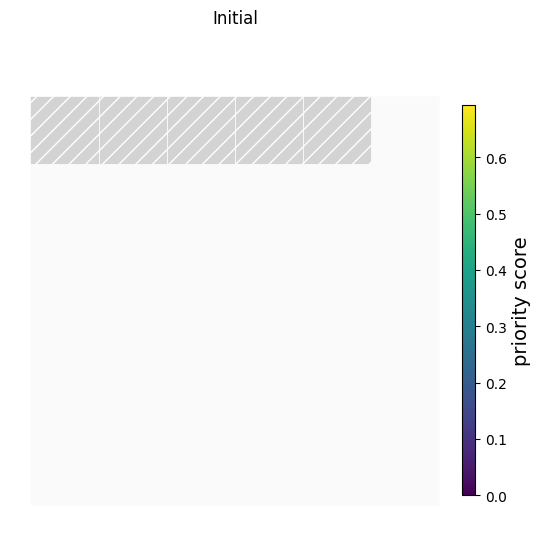

2022-07-08 14:57:47:rastervision.pytorch_learner.learner_config: INFO - Fetching module definition from: /home/adeel/pytorch-fpn
INFO:rastervision.pytorch_learner.learner_config:Fetching module definition from: /home/adeel/pytorch-fpn
2022-07-08 14:57:47:rastervision.pytorch_learner.learner: INFO - epoch: 0
INFO:rastervision.pytorch_learner.learner:epoch: 0


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 14:57:55:rastervision.pytorch_learner.learner: INFO - metrics: {'epoch': 0, 'train_loss': 0.134258975982666, 'train_time': '0:00:07.025818', 'val_loss': 0.173651322722435, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.697551'}
INFO:rastervision.pytorch_learner.learner:metrics: {'epoch': 0, 'train_loss': 0.134258975982666, 'train_time': '0:00:07.025818', 'val_loss': 0.173651322722435, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.697551'}
2022-07-08 14:57:58:rastervision.pytorch_learner.learner: INFO - epoch: 1
INFO:rastervision.pytorch_learner.learner:epoch: 1


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 14:58:06:rastervision.pytorch_learner.learner: INFO - metrics: {'epoch': 1, 'train_loss': 0.10623125076293945, 'train_time': '0:00:07.119832', 'val_loss': 0.15703217685222626, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.697845'}
INFO:rastervision.pytorch_learner.learner:metrics: {'epoch': 1, 'train_loss': 0.10623125076293945, 'train_time': '0:00:07.119832', 'val_loss': 0.15703217685222626, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.697845'}
2022-07-08 14:58:09:rastervision.pytorch_learner.learner: INFO - epoch: 2
INFO:rastervision.pytorch_learner.learner:epoch: 2


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 14:58:17:rastervision.pytorch_learner.learner: INFO - metrics: {'epoch': 2, 'train_loss': 0.0865145492553711, 'train_time': '0:00:06.977246', 'val_loss': 0.09928871691226959, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.649665'}
INFO:rastervision.pytorch_learner.learner:metrics: {'epoch': 2, 'train_loss': 0.0865145492553711, 'train_time': '0:00:06.977246', 'val_loss': 0.09928871691226959, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.649665'}
2022-07-08 14:58:20:rastervision.pytorch_learner.learner: INFO - epoch: 3
INFO:rastervision.pytorch_learner.learner:epoch: 3


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 14:58:28:rastervision.pytorch_learner.learner: INFO - metrics: {'epoch': 3, 'train_loss': 0.06553325653076172, 'train_time': '0:00:06.989524', 'val_loss': 0.1166311725974083, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.658236'}
INFO:rastervision.pytorch_learner.learner:metrics: {'epoch': 3, 'train_loss': 0.06553325653076172, 'train_time': '0:00:06.989524', 'val_loss': 0.1166311725974083, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.658236'}
2022-07-08 14:58:31:rastervision.pytorch_learner.learner: INFO - epoch: 4
INFO:rastervision.pytorch_learner.learner:epoch: 4


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 14:58:38:rastervision.pytorch_learner.learner: INFO - metrics: {'epoch': 4, 'train_loss': 0.06362892150878906, 'train_time': '0:00:06.861022', 'val_loss': 0.09871583431959152, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.674800'}
INFO:rastervision.pytorch_learner.learner:metrics: {'epoch': 4, 'train_loss': 0.06362892150878906, 'train_time': '0:00:06.861022', 'val_loss': 0.09871583431959152, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.674800'}


Predicting:   0%|          | 0/576 [00:00<?, ?it/s]

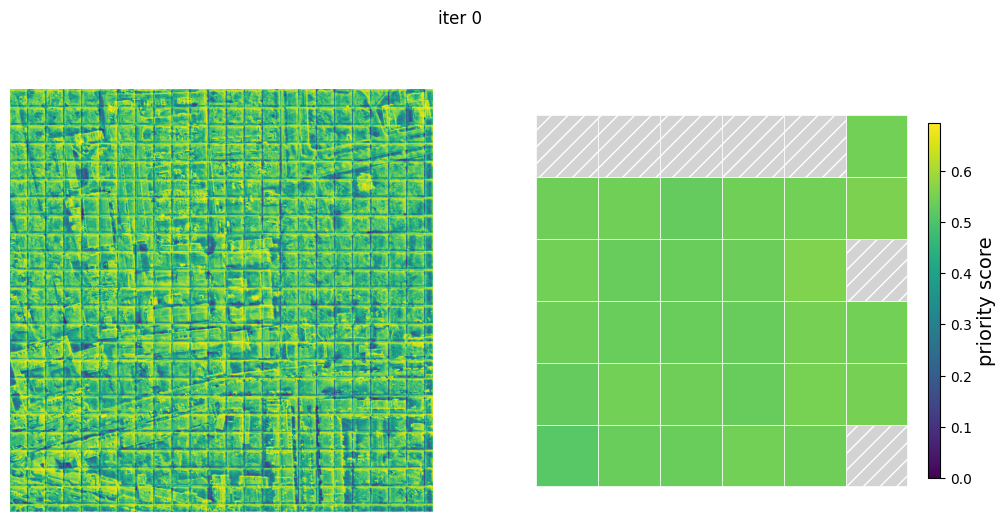

2022-07-08 14:59:54:rastervision.pytorch_learner.learner_config: INFO - Fetching module definition from: /home/adeel/pytorch-fpn
INFO:rastervision.pytorch_learner.learner_config:Fetching module definition from: /home/adeel/pytorch-fpn
2022-07-08 14:59:55:rastervision.pytorch_learner.learner: INFO - epoch: 0
INFO:rastervision.pytorch_learner.learner:epoch: 0


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 15:00:05:rastervision.pytorch_learner.learner: INFO - metrics: {'epoch': 0, 'train_loss': 0.053338636670793804, 'train_time': '0:00:09.614624', 'val_loss': 0.07622256129980087, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.723422'}
INFO:rastervision.pytorch_learner.learner:metrics: {'epoch': 0, 'train_loss': 0.053338636670793804, 'train_time': '0:00:09.614624', 'val_loss': 0.07622256129980087, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.723422'}
2022-07-08 15:00:08:rastervision.pytorch_learner.learner: INFO - epoch: 1
INFO:rastervision.pytorch_learner.learner:epoch: 1


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 15:00:18:rastervision.pytorch_learner.learner: INFO - metrics: {'epoch': 1, 'train_loss': 0.040536083493913924, 'train_time': '0:00:09.750005', 'val_loss': 0.06758236140012741, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.681364'}
INFO:rastervision.pytorch_learner.learner:metrics: {'epoch': 1, 'train_loss': 0.040536083493913924, 'train_time': '0:00:09.750005', 'val_loss': 0.06758236140012741, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.681364'}
2022-07-08 15:00:22:rastervision.pytorch_learner.learner: INFO - epoch: 2
INFO:rastervision.pytorch_learner.learner:epoch: 2


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 15:00:32:rastervision.pytorch_learner.learner: INFO - metrics: {'epoch': 2, 'train_loss': 0.031153913906642367, 'train_time': '0:00:09.742627', 'val_loss': 0.06676691025495529, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.640035'}
INFO:rastervision.pytorch_learner.learner:metrics: {'epoch': 2, 'train_loss': 0.031153913906642367, 'train_time': '0:00:09.742627', 'val_loss': 0.06676691025495529, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.640035'}
2022-07-08 15:00:35:rastervision.pytorch_learner.learner: INFO - epoch: 3
INFO:rastervision.pytorch_learner.learner:epoch: 3


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 15:00:45:rastervision.pytorch_learner.learner: INFO - metrics: {'epoch': 3, 'train_loss': 0.026913091114589147, 'train_time': '0:00:09.684450', 'val_loss': 0.06452568620443344, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.695425'}
INFO:rastervision.pytorch_learner.learner:metrics: {'epoch': 3, 'train_loss': 0.026913091114589147, 'train_time': '0:00:09.684450', 'val_loss': 0.06452568620443344, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.695425'}
2022-07-08 15:00:49:rastervision.pytorch_learner.learner: INFO - epoch: 4
INFO:rastervision.pytorch_learner.learner:epoch: 4


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 15:00:59:rastervision.pytorch_learner.learner: INFO - metrics: {'epoch': 4, 'train_loss': 0.024682743208748952, 'train_time': '0:00:09.703872', 'val_loss': 0.05658918619155884, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.709043'}
INFO:rastervision.pytorch_learner.learner:metrics: {'epoch': 4, 'train_loss': 0.024682743208748952, 'train_time': '0:00:09.703872', 'val_loss': 0.05658918619155884, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.709043'}


Predicting:   0%|          | 0/576 [00:00<?, ?it/s]

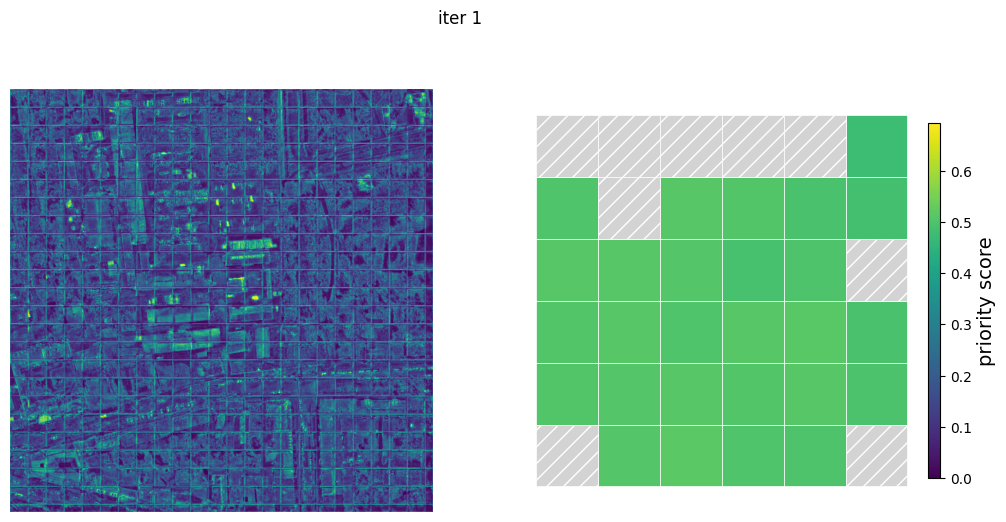

2022-07-08 15:02:17:rastervision.pytorch_learner.learner_config: INFO - Fetching module definition from: /home/adeel/pytorch-fpn
INFO:rastervision.pytorch_learner.learner_config:Fetching module definition from: /home/adeel/pytorch-fpn
2022-07-08 15:02:17:rastervision.pytorch_learner.learner: INFO - epoch: 0
INFO:rastervision.pytorch_learner.learner:epoch: 0


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 15:02:30:rastervision.pytorch_learner.learner: INFO - metrics: {'epoch': 0, 'train_loss': 0.04048188262515598, 'train_time': '0:00:12.583069', 'val_loss': 0.0582243986427784, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.664289'}
INFO:rastervision.pytorch_learner.learner:metrics: {'epoch': 0, 'train_loss': 0.04048188262515598, 'train_time': '0:00:12.583069', 'val_loss': 0.0582243986427784, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.664289'}
2022-07-08 15:02:33:rastervision.pytorch_learner.learner: INFO - epoch: 1
INFO:rastervision.pytorch_learner.learner:epoch: 1


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 15:02:47:rastervision.pytorch_learner.learner: INFO - metrics: {'epoch': 1, 'train_loss': 0.030982796351114908, 'train_time': '0:00:12.869830', 'val_loss': 0.04242352023720741, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.662048'}
INFO:rastervision.pytorch_learner.learner:metrics: {'epoch': 1, 'train_loss': 0.030982796351114908, 'train_time': '0:00:12.869830', 'val_loss': 0.04242352023720741, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.662048'}
2022-07-08 15:02:50:rastervision.pytorch_learner.learner: INFO - epoch: 2
INFO:rastervision.pytorch_learner.learner:epoch: 2


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 15:03:03:rastervision.pytorch_learner.learner: INFO - metrics: {'epoch': 2, 'train_loss': 0.03136953247918023, 'train_time': '0:00:12.562104', 'val_loss': 0.07007783651351929, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.668778'}
INFO:rastervision.pytorch_learner.learner:metrics: {'epoch': 2, 'train_loss': 0.03136953247918023, 'train_time': '0:00:12.562104', 'val_loss': 0.07007783651351929, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.668778'}
2022-07-08 15:03:06:rastervision.pytorch_learner.learner: INFO - epoch: 3
INFO:rastervision.pytorch_learner.learner:epoch: 3


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 15:03:19:rastervision.pytorch_learner.learner: INFO - metrics: {'epoch': 3, 'train_loss': 0.028567110167609322, 'train_time': '0:00:12.254974', 'val_loss': 0.060646723955869675, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.685102'}
INFO:rastervision.pytorch_learner.learner:metrics: {'epoch': 3, 'train_loss': 0.028567110167609322, 'train_time': '0:00:12.254974', 'val_loss': 0.060646723955869675, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.685102'}
2022-07-08 15:03:22:rastervision.pytorch_learner.learner: INFO - epoch: 4
INFO:rastervision.pytorch_learner.learner:epoch: 4


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 15:03:35:rastervision.pytorch_learner.learner: INFO - metrics: {'epoch': 4, 'train_loss': 0.023731136322021486, 'train_time': '0:00:12.263613', 'val_loss': 0.03958883881568909, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.694232'}
INFO:rastervision.pytorch_learner.learner:metrics: {'epoch': 4, 'train_loss': 0.023731136322021486, 'train_time': '0:00:12.263613', 'val_loss': 0.03958883881568909, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.694232'}


Predicting:   0%|          | 0/576 [00:00<?, ?it/s]

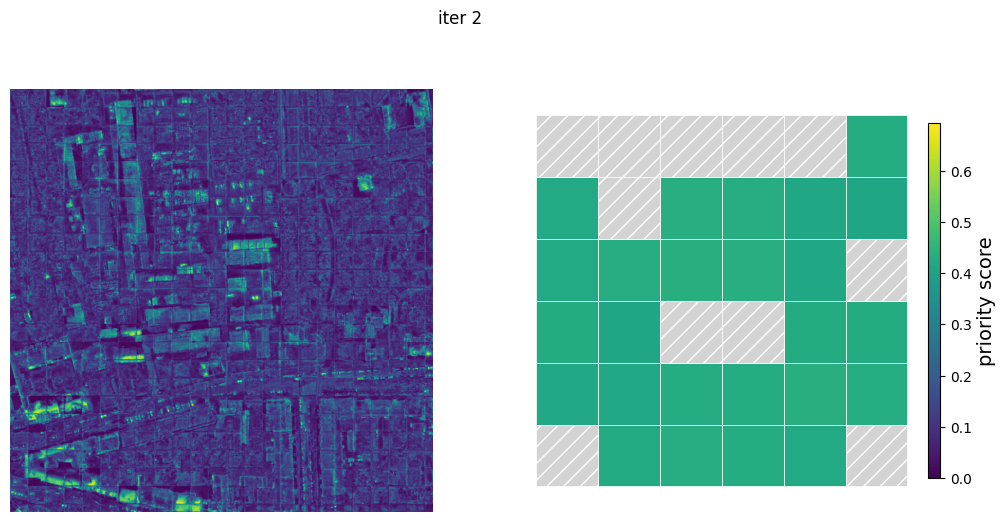

2022-07-08 15:04:52:rastervision.pytorch_learner.learner_config: INFO - Fetching module definition from: /home/adeel/pytorch-fpn
INFO:rastervision.pytorch_learner.learner_config:Fetching module definition from: /home/adeel/pytorch-fpn
2022-07-08 15:04:52:rastervision.pytorch_learner.learner: INFO - epoch: 0
INFO:rastervision.pytorch_learner.learner:epoch: 0


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 15:05:08:rastervision.pytorch_learner.learner: INFO - metrics: {'epoch': 0, 'train_loss': 0.03968606862154874, 'train_time': '0:00:15.229740', 'val_loss': 0.05803869292140007, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.683687'}
INFO:rastervision.pytorch_learner.learner:metrics: {'epoch': 0, 'train_loss': 0.03968606862154874, 'train_time': '0:00:15.229740', 'val_loss': 0.05803869292140007, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.683687'}
2022-07-08 15:05:11:rastervision.pytorch_learner.learner: INFO - epoch: 1
INFO:rastervision.pytorch_learner.learner:epoch: 1


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 15:05:27:rastervision.pytorch_learner.learner: INFO - metrics: {'epoch': 1, 'train_loss': 0.033601205999200995, 'train_time': '0:00:15.304118', 'val_loss': 0.05648467689752579, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.660439'}
INFO:rastervision.pytorch_learner.learner:metrics: {'epoch': 1, 'train_loss': 0.033601205999200995, 'train_time': '0:00:15.304118', 'val_loss': 0.05648467689752579, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.660439'}
2022-07-08 15:05:30:rastervision.pytorch_learner.learner: INFO - epoch: 2
INFO:rastervision.pytorch_learner.learner:epoch: 2


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 15:05:46:rastervision.pytorch_learner.learner: INFO - metrics: {'epoch': 2, 'train_loss': 0.026829931952736596, 'train_time': '0:00:15.026133', 'val_loss': 0.06565239280462265, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.715954'}
INFO:rastervision.pytorch_learner.learner:metrics: {'epoch': 2, 'train_loss': 0.026829931952736596, 'train_time': '0:00:15.026133', 'val_loss': 0.06565239280462265, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.715954'}
2022-07-08 15:05:49:rastervision.pytorch_learner.learner: INFO - epoch: 3
INFO:rastervision.pytorch_learner.learner:epoch: 3


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 15:06:05:rastervision.pytorch_learner.learner: INFO - metrics: {'epoch': 3, 'train_loss': 0.02487748536196622, 'train_time': '0:00:15.203401', 'val_loss': 0.03930395841598511, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.721076'}
INFO:rastervision.pytorch_learner.learner:metrics: {'epoch': 3, 'train_loss': 0.02487748536196622, 'train_time': '0:00:15.203401', 'val_loss': 0.03930395841598511, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.721076'}
2022-07-08 15:06:08:rastervision.pytorch_learner.learner: INFO - epoch: 4
INFO:rastervision.pytorch_learner.learner:epoch: 4


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 15:06:24:rastervision.pytorch_learner.learner: INFO - metrics: {'epoch': 4, 'train_loss': 0.021467750722711735, 'train_time': '0:00:15.379292', 'val_loss': 0.04816205054521561, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.699868'}
INFO:rastervision.pytorch_learner.learner:metrics: {'epoch': 4, 'train_loss': 0.021467750722711735, 'train_time': '0:00:15.379292', 'val_loss': 0.04816205054521561, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.699868'}


Predicting:   0%|          | 0/576 [00:00<?, ?it/s]

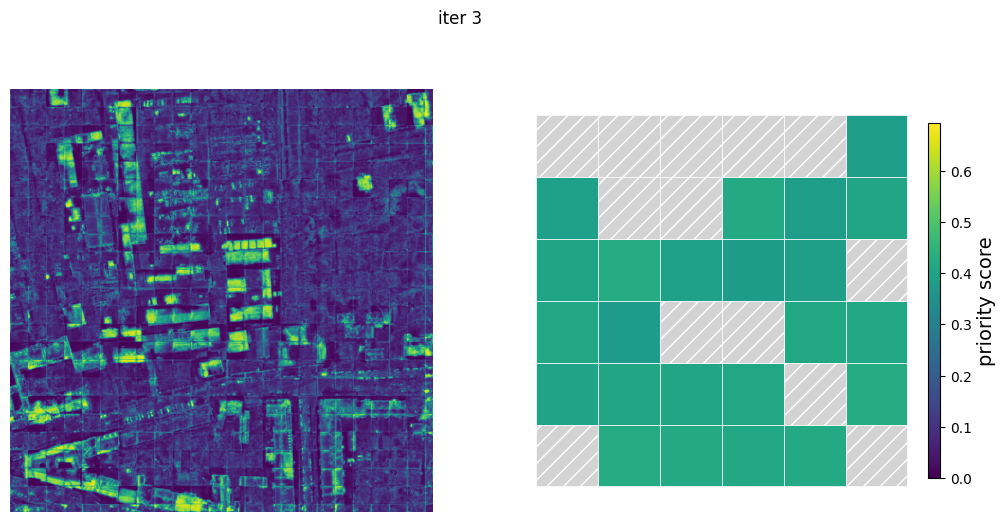

2022-07-08 15:07:42:rastervision.pytorch_learner.learner_config: INFO - Fetching module definition from: /home/adeel/pytorch-fpn
INFO:rastervision.pytorch_learner.learner_config:Fetching module definition from: /home/adeel/pytorch-fpn
2022-07-08 15:07:42:rastervision.pytorch_learner.learner: INFO - epoch: 0
INFO:rastervision.pytorch_learner.learner:epoch: 0


Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 15:08:00:rastervision.pytorch_learner.learner: INFO - metrics: {'epoch': 0, 'train_loss': 0.034137282004723185, 'train_time': '0:00:17.721869', 'val_loss': 0.04822830483317375, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.690204'}
INFO:rastervision.pytorch_learner.learner:metrics: {'epoch': 0, 'train_loss': 0.034137282004723185, 'train_time': '0:00:17.721869', 'val_loss': 0.04822830483317375, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.690204'}
2022-07-08 15:08:03:rastervision.pytorch_learner.learner: INFO - epoch: 1
INFO:rastervision.pytorch_learner.learner:epoch: 1


Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 15:08:22:rastervision.pytorch_learner.learner: INFO - metrics: {'epoch': 1, 'train_loss': 0.029004694865300107, 'train_time': '0:00:18.183702', 'val_loss': 0.06075282022356987, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.680210'}
INFO:rastervision.pytorch_learner.learner:metrics: {'epoch': 1, 'train_loss': 0.029004694865300107, 'train_time': '0:00:18.183702', 'val_loss': 0.06075282022356987, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.680210'}
2022-07-08 15:08:25:rastervision.pytorch_learner.learner: INFO - epoch: 2
INFO:rastervision.pytorch_learner.learner:epoch: 2


Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 15:08:44:rastervision.pytorch_learner.learner: INFO - metrics: {'epoch': 2, 'train_loss': 0.026244090153620794, 'train_time': '0:00:18.160083', 'val_loss': 0.09163284301757812, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.661853'}
INFO:rastervision.pytorch_learner.learner:metrics: {'epoch': 2, 'train_loss': 0.026244090153620794, 'train_time': '0:00:18.160083', 'val_loss': 0.09163284301757812, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.661853'}
2022-07-08 15:08:47:rastervision.pytorch_learner.learner: INFO - epoch: 3
INFO:rastervision.pytorch_learner.learner:epoch: 3


Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 15:09:06:rastervision.pytorch_learner.learner: INFO - metrics: {'epoch': 3, 'train_loss': 0.022514897126417893, 'train_time': '0:00:18.001173', 'val_loss': 0.028959471732378006, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.659713'}
INFO:rastervision.pytorch_learner.learner:metrics: {'epoch': 3, 'train_loss': 0.022514897126417893, 'train_time': '0:00:18.001173', 'val_loss': 0.028959471732378006, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.659713'}
2022-07-08 15:09:09:rastervision.pytorch_learner.learner: INFO - epoch: 4
INFO:rastervision.pytorch_learner.learner:epoch: 4


Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-08 15:09:28:rastervision.pytorch_learner.learner: INFO - metrics: {'epoch': 4, 'train_loss': 0.025722934649540827, 'train_time': '0:00:17.958816', 'val_loss': 0.026951981708407402, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.679965'}
INFO:rastervision.pytorch_learner.learner:metrics: {'epoch': 4, 'train_loss': 0.025722934649540827, 'train_time': '0:00:17.958816', 'val_loss': 0.026951981708407402, 'avg_precision': 0.0, 'avg_recall': 0.0, 'avg_f1': 0.0, 'valid_time': '0:00:00.679965'}


Predicting:   0%|          | 0/576 [00:00<?, ?it/s]

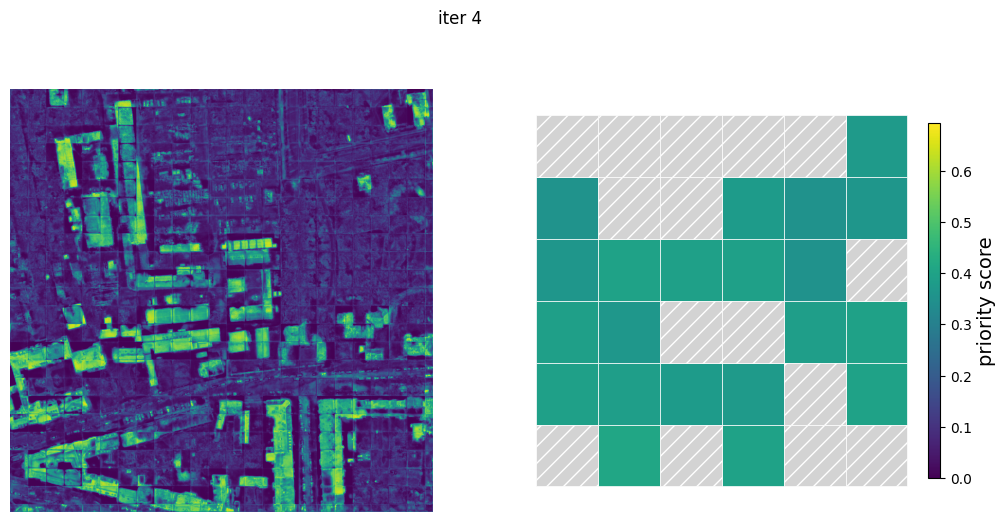

In [55]:
img_info = make_fake_img_info('')
task_grid = make_fake_task_grid(img_info, task_size=1024, nlabeled=5)

out_task_grid = al_loop(
    niters=5,
    class_config=ClassConfig(names=['bg', 'fg'], null_class='bg'),
    img_info=img_info, 
    task_grid=task_grid,
    labels_uri='',
    ntasks_per_iter=2,
    output_dir='test-run-1',
    train_kw=dict(num_epochs=5, img_sz=256),
    predict_kw=dict(chip_sz=256, stride=256))

In [56]:
task_grid

,id,status,score,geometry
0,00d0f4e5-25b8-462f-8659-0f820743011f,VALIDATED,-inf,"POLYGON ((366427.725 5807311.375, 366427.725 5..."
1,40cc8446-55d6-4c0c-a85b-6168535e311e,VALIDATED,-inf,"POLYGON ((366478.925 5807311.375, 366478.925 5..."
2,c3a9d012-68b0-48aa-95aa-5044f1216196,VALIDATED,-inf,"POLYGON ((366530.125 5807311.375, 366530.125 5..."
3,acc77f1d-b791-44dc-b3aa-17cf62ebf5bd,VALIDATED,-inf,"POLYGON ((366581.325 5807311.375, 366581.325 5..."
4,ec6278ef-11bb-4740-ae53-6e00a8527951,VALIDATED,-inf,"POLYGON ((366632.525 5807311.375, 366632.525 5..."
5,60a42a06-fde6-41db-91e8-19314c4bce16,UNLABELED,0.375488,"POLYGON ((366683.725 5807311.375, 366683.725 5..."
6,eadbc53a-baa7-4650-a11d-ffe339776c05,UNLABELED,0.355713,"POLYGON ((366427.725 5807260.175, 366427.725 5..."
7,35cb0a8b-fc52-4439-91e8-bec0730fa45f,VALIDATED,-inf,"POLYGON ((366478.925 5807260.175, 366478.925 5..."
8,45f61750-6ead-408a-9416-181b35633054,VALIDATED,-inf,"POLYGON ((366530.125 5807260.175, 366530.125 5..."
9,646e346a-800e-426c-810e-3e4d0a0e70f1,UNLABELED,0.377686,"POLYGON ((366581.325 5807260.175, 366581.325 5..."


---

In [7]:
img_info = make_fake_img_info('')
task_grid = make_fake_task_grid(img_info, task_size=500, nlabeled=10)

In [8]:
scene = make_scene(
    scene_id='test_scene',
    class_config=ClassConfig(
        names=['bg', 'fg'], colors=['lightgray', 'darkred'], null_class='bg'),
    img_info=img_info,
    labels_uri='',
    aoi=[]
)

In [ ]:
with scene.activate():
    x, y = scene[Box(0, 0, 1024, 1024)]

---